In [1]:
# SELDA 1: Importaciones y configuración inicial
import os
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import pybullet as p
import pybullet_data
from tqdm import tqdm

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"Usando dispositivo: {device}")
print(f"PyTorch version: {torch.__version__}")


Usando dispositivo: cuda
PyTorch version: 2.5.1+cu121


In [2]:
# SELDA 2: Clases base del robot
class Models:
    def load_objects(self):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError
    def __getitem__(self, item):
        return NotImplementedError

class YCBModels(Models):
    def __init__(self, root, selected_names: tuple = ()):
        self.obj_files = []
        self.selected_names = selected_names
        self.visual_shapes = []
        self.collision_shapes = []
    def load_objects(self):
        pass
    def __len__(self):
        return len(self.collision_shapes)
    def __getitem__(self, idx):
        return self.visual_shapes[idx], self.collision_shapes[idx]

class Camera:
    def __init__(self, cam_pos, cam_tar, cam_up_vector, near, far, size, fov):
        self.width, self.height = size
        self.near, self.far = near, far
        self.fov = fov
        aspect = self.width / self.height
        self.view_matrix = p.computeViewMatrix(cam_pos, cam_tar, cam_up_vector)
        self.projection_matrix = p.computeProjectionMatrixFOV(self.fov, aspect, self.near, self.far)
    def shot(self):
        _w, _h, rgb, depth, seg = p.getCameraImage(self.width, self.height,
                                                   self.view_matrix, self.projection_matrix)
        return rgb, depth, seg

class RobotBase(object):
    def __init__(self, pos, ori):
        self.base_pos = pos
        self.base_ori = p.getQuaternionFromEuler(ori)

    def load(self):
        self.__init_robot__()
        self.__parse_joint_info__()
        self.__post_load__()

    def step_simulation(self):
        raise RuntimeError('step_simulation method should be hooked by the environment.')

    def __parse_joint_info__(self):
        numJoints = p.getNumJoints(self.id)
        jointInfo = namedtuple('jointInfo', 
            ['id','name','type','damping','friction','lowerLimit','upperLimit','maxForce','maxVelocity','controllable'])
        self.joints = []
        self.controllable_joints = []
        
        for i in range(numJoints):
            info = p.getJointInfo(self.id, i)
            jointID = info[0]
            jointName = info[1].decode("utf-8")
            jointType = info[2]
            jointDamping = info[6]
            jointFriction = info[7]
            jointLowerLimit = info[8]
            jointUpperLimit = info[9]
            jointMaxForce = info[10]
            jointMaxVelocity = info[11]
            controllable = (jointType != p.JOINT_FIXED)
            
            if controllable:
                self.controllable_joints.append(jointID)
                p.setJointMotorControl2(self.id, jointID, p.VELOCITY_CONTROL, targetVelocity=0, force=0)
            
            info = jointInfo(jointID,jointName,jointType,jointDamping,jointFriction,jointLowerLimit,
                            jointUpperLimit,jointMaxForce,jointMaxVelocity,controllable)
            self.joints.append(info)

        assert len(self.controllable_joints) >= self.arm_num_dofs
        self.arm_controllable_joints = self.controllable_joints[:self.arm_num_dofs]
        self.arm_lower_limits = [info.lowerLimit for info in self.joints if info.controllable][:self.arm_num_dofs]
        self.arm_upper_limits = [info.upperLimit for info in self.joints if info.controllable][:self.arm_num_dofs]
        self.arm_joint_ranges = [info.upperLimit - info.lowerLimit for info in self.joints if info.controllable][:self.arm_num_dofs]

    def __init_robot__(self):
        raise NotImplementedError
    
    def __post_load__(self):
        pass

    def reset(self):
        self.reset_arm()
        self.reset_gripper()

    def reset_arm(self):
        for rest_pose, joint_id in zip(self.arm_rest_poses, self.arm_controllable_joints):
            p.resetJointState(self.id, joint_id, rest_pose)
        for _ in range(10):
            self.step_simulation()

    def reset_gripper(self):
        self.open_gripper()

    def open_gripper(self):
        self.move_gripper(self.gripper_range[1])

    def close_gripper(self):
        self.move_gripper(self.gripper_range[0])

    def move_ee(self, action, control_method):
        assert control_method in ('joint', 'end')
        if control_method == 'end':
            x, y, z, roll, pitch, yaw = action
            pos = (x, y, z)
            orn = p.getQuaternionFromEuler((roll, pitch, yaw))
            joint_poses = p.calculateInverseKinematics(self.id, self.eef_id, pos, orn,
                                                       self.arm_lower_limits, self.arm_upper_limits, 
                                                       self.arm_joint_ranges, self.arm_rest_poses,
                                                       maxNumIterations=20)
        elif control_method == 'joint':
            assert len(action) == self.arm_num_dofs
            joint_poses = action
            
        for i, joint_id in enumerate(self.arm_controllable_joints):
            p.setJointMotorControl2(self.id, joint_id, p.POSITION_CONTROL, joint_poses[i],
                                    force=self.joints[joint_id].maxForce, 
                                    maxVelocity=self.joints[joint_id].maxVelocity)

    def move_gripper(self, open_length):
        raise NotImplementedError

    def get_joint_obs(self):
        positions = []
        velocities = []
        for joint_id in self.controllable_joints:
            pos, vel, _, _ = p.getJointState(self.id, joint_id)
            positions.append(pos)
            velocities.append(vel)
        ee_pos = p.getLinkState(self.id, self.eef_id)[0]
        return dict(positions=positions, velocities=velocities, ee_pos=ee_pos)

class UR5Robotiq85(RobotBase):
    def __init_robot__(self):
        self.eef_id = 7
        self.arm_num_dofs = 6
        self.arm_rest_poses = [-1.5690622952052096, -1.5446774605904932, 1.343946009733127, 
                               -1.3708613585093699, -1.5707970583733368, 0.0009377758247187636]
        
        try:
            self.id = p.loadURDF('./urdf/ur5_robotiq_85.urdf', self.base_pos, self.base_ori,
                                 useFixedBase=True, flags=p.URDF_ENABLE_CACHED_GRAPHICS_SHAPES)
            print("Robot UR5 cargado desde URDF")
        except:
            print("URDF no encontrado, creando robot simplificado...")
            self.id = self._create_simple_robot()
            
        self.gripper_range = [0, 0.085]
    
    def _create_simple_robot(self):
        base_shape = p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.05])
        base_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.05], rgbaColor=[0.7, 0.7, 0.7, 1])
        
        link_masses = [1.0] * 7
        link_collision_shapes = []
        link_visual_shapes = []
        link_positions = []
        link_orientations = []
        link_inertial_positions = []
        link_inertial_orientations = []
        parent_indices = []
        joint_types = []
        joint_axes = []
        
        for i in range(7):
            if i < 6:
                link_collision_shapes.append(p.createCollisionShape(p.GEOM_CYLINDER, 
                                                                   halfExtents=[0.05, 0.05, 0.1]))
                link_visual_shapes.append(p.createVisualShape(p.GEOM_CYLINDER, 
                                                            halfExtents=[0.05, 0.05, 0.1],
                                                            rgbaColor=[0.5, 0.5, 0.8, 1]))
                joint_types.append(p.JOINT_REVOLUTE)
                joint_axes.append([0, 0, 1] if i % 2 == 0 else [1, 0, 0])
            else:
                link_collision_shapes.append(p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.02, 0.02, 0.05]))
                link_visual_shapes.append(p.createVisualShape(p.GEOM_BOX, halfExtents=[0.02, 0.02, 0.05], 
                                                            rgbaColor=[0.8, 0.2, 0.2, 1]))
                joint_types.append(p.JOINT_FIXED)
                joint_axes.append([0, 0, 1])
            
            link_positions.append([0, 0, 0.2])
            link_orientations.append([0, 0, 0, 1])
            link_inertial_positions.append([0, 0, 0])
            link_inertial_orientations.append([0, 0, 0, 1])
            parent_indices.append(i)
        
        robot_id = p.createMultiBody(
            baseMass=5.0,
            baseCollisionShapeIndex=base_shape,
            baseVisualShapeIndex=base_visual,
            basePosition=self.base_pos,
            baseOrientation=self.base_ori,
            linkMasses=link_masses,
            linkCollisionShapeIndices=link_collision_shapes,
            linkVisualShapeIndices=link_visual_shapes,
            linkPositions=link_positions,
            linkOrientations=link_orientations,
            linkInertialFramePositions=link_inertial_positions,
            linkInertialFrameOrientations=link_inertial_orientations,
            linkParentIndices=parent_indices,
            linkJointTypes=joint_types,
            linkJointAxis=joint_axes
        )
        return robot_id
    
    def __post_load__(self):
        pass

    def move_gripper(self, open_length):
        pass

In [3]:
# SELDA 3: Demo de visualización
def demo_robot_visualization():
    print("Iniciando demo de visualización del brazo robótico...")
    print("Instrucciones:")
    print("- Se abrirá PyBullet mostrando el brazo UR5")
    print("- El brazo hará movimientos suaves de demostración")
    print("- Cierra la ventana o presiona Ctrl+C para terminar")
    
    physics_client = p.connect(p.GUI)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setGravity(0, 0, -9.81)
    
    plane_id = p.loadURDF("plane.urdf")
    
    robot = UR5Robotiq85((0, 0, 0), (0, 0, 0))
    robot.step_simulation = lambda: p.stepSimulation()
    robot.load()
    
    print(f"Robot cargado con {len(robot.controllable_joints)} joints controlables")
    print(f"End effector ID: {robot.eef_id}")
    
    p.resetDebugVisualizerCamera(
        cameraDistance=1.5,
        cameraYaw=45,
        cameraPitch=-30,
        cameraTargetPosition=[0, 0, 0.5]
    )
    
    ref_objects = []
    for i, (x, y) in enumerate([(0.3, 0.3), (0.3, -0.3), (0.5, 0), (0.2, 0)]):
        marker_visual = p.createVisualShape(p.GEOM_SPHERE, radius=0.02, 
                                          rgbaColor=[1.0, 0.5, 0.0, 0.8])
        marker_id = p.createMultiBody(baseMass=0,
                                    baseVisualShapeIndex=marker_visual,
                                    basePosition=[x, y, 0.1])
        ref_objects.append(marker_id)
    
    print("Marcadores de referencia creados en el espacio de trabajo")
    
    t = 0
    demo_duration = 30
    step_time = 1/240
    
    print(f"Iniciando demo por {demo_duration} segundos...")
    print("El brazo realizará movimientos suaves y coordinados")
    
    try:
        start_time = time.time()
        
        while time.time() - start_time < demo_duration:
            t += step_time
            
            joint_targets = []
            for i in range(robot.arm_num_dofs):
                amplitude = 0.5 + 0.3 * math.sin(0.1 * t + i)
                frequency = 0.3 + 0.1 * i
                offset = robot.arm_rest_poses[i]
                
                target = offset + amplitude * math.sin(frequency * t + i * math.pi/3)
                target = max(robot.arm_lower_limits[i], 
                           min(robot.arm_upper_limits[i], target))
                joint_targets.append(target)
            
            robot.move_ee(joint_targets, 'joint')
            
            if int(t) % 5 == 0 and abs(t - int(t)) < step_time:
                ee_pos = p.getLinkState(robot.id, robot.eef_id)[0]
                print(f"Tiempo: {int(t)}s - End effector en: ({ee_pos[0]:.2f}, {ee_pos[1]:.2f}, {ee_pos[2]:.2f})")
            
            p.stepSimulation()
            time.sleep(step_time)
            
    except KeyboardInterrupt:
        print("Demo interrumpido por el usuario")
    
    print("Demo de visualización completado")
    print("Regresando robot a posición de descanso...")
    
    robot.reset_arm()
    for _ in range(60):
        p.stepSimulation()
        time.sleep(step_time)
    
    print("El entorno permanece abierto para inspección")
    print("Cierra la ventana de PyBullet cuando hayas terminado")
    
    input("Presiona Enter cuando quieras cerrar el entorno...")
    p.disconnect(physics_client)
    print("Demo de visualización terminado")


In [4]:
# SELDA 4: Entorno de entrenamiento
class CupFlipEnv:
    def __init__(self, robot_type='UR5', vis=False, render_mode=None):
        self.vis = vis
        self.render_mode = render_mode
        self.robot_type = robot_type
        
        if self.vis:
            self.physics_client = p.connect(p.GUI)
            print("Entorno creado con visualización")
        else:
            self.physics_client = p.connect(p.DIRECT)
            print("Entorno creado sin visualización (modo rápido)")
            
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)
        
        self.plane_id = p.loadURDF("plane.urdf")
        
        if robot_type == 'UR5':
            self.robot = UR5Robotiq85((0, 0, 0), (0, 0, 0))
        else:
            raise ValueError("Solo UR5 está disponible en esta versión")
            
        self.robot.load()
        self.robot.step_simulation = self.step_simulation
        
        self.cup_id = None
        self.cup_initial_pos = None
        self.cup_initial_orn = None
        self.workspace_bounds = [-0.8, 0.8, -0.5, 0.5, 0.0, 0.3]  # Workspace ampliado
        
        self.max_steps = 200
        self.current_step = 0
        self.cup_flipped = False
        
        self.action_dim = 6
        self.obs_dim = 19
        
        print(f"Entorno inicializado:")
        print(f"- Robot: {robot_type}")
        print(f"- Dimensión de acción: {self.action_dim}")
        print(f"- Dimensión de observación: {self.obs_dim}")
        print(f"- Pasos máximos por episodio: {self.max_steps}")
        
    def step_simulation(self):
        p.stepSimulation()
        if self.vis:
            time.sleep(1/240)
    
    def reset(self):
        self.current_step = 0
        self.cup_flipped = False
        
        self.robot.reset()
        
        # Eliminar vaso anterior si existe
        if self.cup_id is not None:
            p.removeBody(self.cup_id)
        
        self._spawn_cup()
        
        for _ in range(50):
            self.step_simulation()
            
        return self._get_observation()
    
    def _spawn_cup(self):
        # Posición más alejada del robot para mayor desafío
        x = random.uniform(0.7, 0.9)  # Más lejos: 40-70cm del robot
        y = random.uniform(-0.3, 0.3)  # Rango lateral ampliado
        z = 0.05  # Altura sobre la mesa (ajustada para vaso más alto)
        
        self.cup_initial_pos = [x, y, z]
        self.cup_initial_orn = p.getQuaternionFromEuler([0, 0, random.uniform(0, 2*math.pi)])
        
        # DIMENSIONES DEL VASO DE BRAZO1.PY
        cup_radius = 0.03    # 3 cm de radio = 6 cm de diámetro
        cup_height = 0.08    # 8 cm de altura
        
        # Crear el vaso con colores distintivos (ROJO como en brazo1.py)
        cup_collision = p.createCollisionShape(p.GEOM_CYLINDER, 
                                             radius=cup_radius, 
                                             height=cup_height)
        cup_visual = p.createVisualShape(p.GEOM_CYLINDER, 
                                       radius=cup_radius, 
                                       length=cup_height,
                                       rgbaColor=[0.8, 0.2, 0.2, 1.0])  # ROJO como en brazo1.py
        
        self.cup_id = p.createMultiBody(baseMass=0.1,  # 100 gramos
                                      baseCollisionShapeIndex=cup_collision,
                                      baseVisualShapeIndex=cup_visual,
                                      basePosition=self.cup_initial_pos,
                                      baseOrientation=self.cup_initial_orn)
        
        # PROPIEDADES FÍSICAS COMO EN BRAZO1.PY
        p.changeDynamics(self.cup_id, -1, 
                        lateralFriction=0.8, 
                        spinningFriction=0.3, 
                        rollingFriction=0.1, 
                        restitution=0.2)
        
        print(f"Vaso creado (brazo1.py): diametro={cup_radius*2*100:.1f}cm, altura={cup_height*100:.1f}cm")
        print(f"Posicion alejada del robot: ({x:.3f}, {y:.3f}, {z:.3f})")
    
    def step(self, action):
        self.current_step += 1
        
        action = np.clip(action, -1, 1)
        
        joint_commands = []
        for i, joint_action in enumerate(action):
            joint_range = self.robot.arm_upper_limits[i] - self.robot.arm_lower_limits[i]
            joint_cmd = self.robot.arm_lower_limits[i] + (joint_action + 1) * 0.5 * joint_range
            joint_commands.append(joint_cmd)
        
        self.robot.move_ee(joint_commands, 'joint')
        
        for _ in range(10):
            self.step_simulation()
        
        reward = self._calculate_reward()
        done = self._is_done()
        
        info = {
            'cup_flipped': self.cup_flipped,
            'step': self.current_step
        }
        
        return self._get_observation(), reward, done, info
    
    def _get_observation(self):
        obs = []
        
        joint_states = self.robot.get_joint_obs()
        obs.extend(joint_states['positions'][:6])
        obs.extend(joint_states['velocities'][:6])
        obs.extend(joint_states['ee_pos'])
        
        if self.cup_id is not None:
            cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cup_id)
            obs.extend(cup_pos)
            
            cup_euler = p.getEulerFromQuaternion(cup_orn)
            tilt_angle = abs(cup_euler[0]) + abs(cup_euler[1])
            obs.append(tilt_angle)
        else:
            obs.extend([0, 0, 0, 0])
        
        return np.array(obs, dtype=np.float32)
    
    def _calculate_reward(self):
        reward = 0
        
        if self.cup_id is None:
            return -10
        
        cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cup_id)
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        
        ee_pos = p.getLinkState(self.robot.id, self.robot.eef_id)[0]
        
        # Distancia al vaso
        distance_to_cup = np.linalg.norm(np.array(ee_pos) - np.array(cup_pos))
        
        # Recompensa por proximidad al vaso
        proximity_reward = max(0, 1.0 - distance_to_cup)
        reward += proximity_reward * 2.0
        
        roll, pitch, yaw = cup_euler
        tilt_angle = abs(roll) + abs(pitch)
        
        # Umbral para voltear el vaso (30 grados)
        if tilt_angle > math.pi/6:  
            if not self.cup_flipped:
                self.cup_flipped = True
                reward += 100  # Recompensa por voltear el vaso
                print(f"¡Vaso volteado en el paso {self.current_step}!")
            else:
                reward += 20  # Mantener el vaso volteado
        
        # Recompensa por inclinación parcial
        reward += tilt_angle * 15
        
        # Penalización por tiempo
        reward -= 0.1
        
        # Penalización si el vaso se cae
        if cup_pos[2] < -0.02:
            reward -= 50
        
        # Recompensas por proximidad (ajustadas para vaso más alejado)
        if distance_to_cup < 0.15:  # 15cm (ajustado para mayor distancia)
            reward += 5
        if distance_to_cup < 0.10:  # 10cm (ajustado para mayor distancia)
            reward += 10
        
        return reward
    
    def _is_done(self):
        if self.current_step >= self.max_steps:
            return True
        
        if self.cup_id is None:
            return True
        
        # Verificar si el vaso se cayó (ajustado para vaso más alto)
        cup_pos, _ = p.getBasePositionAndOrientation(self.cup_id)
        if cup_pos[2] < -0.04:  # Umbral ajustado para vaso más alto
            return True
        
        # Terminar si el vaso está volteado por un tiempo (más tiempo para observar)
        if self.cup_flipped and self.current_step > 75:
            return True
        
        return False
    
    def close(self):
        p.disconnect(self.physics_client)
        print("Entorno cerrado")

In [5]:
# SELDA 5: Red neuronal y algoritmo PPO
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super(ActorCritic, self).__init__()
        
        print(f"Creando red neuronal:")
        print(f"- Entrada: {obs_dim} neuronas")
        print(f"- Capas ocultas: {hidden_dim} neuronas")
        print(f"- Salida del actor: {action_dim} acciones")
        print(f"- Salida del critic: 1 valor")
        
        self.shared_layers = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU()
        )
        
        self.actor_mean = nn.Linear(hidden_dim//2, action_dim)
        self.actor_logstd = nn.Parameter(torch.zeros(action_dim))
        
        self.critic = nn.Linear(hidden_dim//2, 1)
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.constant_(m.bias, 0)
        
        nn.init.orthogonal_(self.actor_mean.weight, gain=0.01)
        
    def forward(self, state):
        shared = self.shared_layers(state)
        return shared
    
    def act(self, state):
        shared = self.forward(state)
        action_mean = self.actor_mean(shared)
        action_std = torch.exp(self.actor_logstd)
        
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        action_logprob = dist.log_prob(action).sum(dim=-1)
        
        return action, action_logprob
    
    def evaluate(self, state, action):
        shared = self.forward(state)
        action_mean = self.actor_mean(shared)
        action_std = torch.exp(self.actor_logstd)
        
        dist = Normal(action_mean, action_std)
        action_logprob = dist.log_prob(action).sum(dim=-1)
        dist_entropy = dist.entropy().sum(dim=-1)
        state_value = self.critic(shared).squeeze()
        
        return action_logprob, state_value, dist_entropy

class PPOAgent:
    def __init__(self, obs_dim, action_dim, lr=1e-4, gamma=0.99, eps_clip=0.2, 
                 k_epochs=4, hidden_dim=256):
        
        print(f"Inicializando agente PPO:")
        print(f"- Learning rate: {lr}")
        print(f"- Gamma (descuento): {gamma}")
        print(f"- Epsilon clip: {eps_clip}")
        print(f"- Épocas de actualización: {k_epochs}")
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        
        self.policy = ActorCritic(obs_dim, action_dim, hidden_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.policy_old = ActorCritic(obs_dim, action_dim, hidden_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
        
        self.buffer = []
        
        self.training_stats = {
            'actor_losses': [],
            'critic_losses': [],
            'entropy_losses': [],
            'total_losses': []
        }
        
        print("Agente PPO inicializado correctamente")
        
    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            action, action_logprob = self.policy_old.act(state)
        
        return action.cpu().numpy().flatten(), action_logprob.cpu().numpy().flatten()
    
    def store_transition(self, state, action, action_logprob, reward, next_state, done):
        self.buffer.append((state, action, action_logprob, reward, next_state, done))
    
    def update(self):
        if len(self.buffer) == 0:
            return
        
        print(f"Actualizando política con {len(self.buffer)} experiencias...")
        
        states = torch.FloatTensor([t[0] for t in self.buffer])
        actions = torch.FloatTensor([t[1] for t in self.buffer])
        old_logprobs = torch.FloatTensor([t[2] for t in self.buffer])
        rewards = [t[3] for t in self.buffer]
        next_states = torch.FloatTensor([t[4] for t in self.buffer])
        dones = [t[5] for t in self.buffer]
        
        discounted_rewards = []
        discounted_reward = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            discounted_rewards.insert(0, discounted_reward)
        
        discounted_rewards = torch.FloatTensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)
        
        epoch_actor_losses = []
        epoch_critic_losses = []
        epoch_entropy_losses = []
        epoch_total_losses = []
        
        for epoch in range(self.k_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(states, actions)
            
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            advantages = discounted_rewards - state_values.detach()
            
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            critic_loss = self.MseLoss(state_values, discounted_rewards)
            
            entropy_loss = -0.01 * dist_entropy.mean()
            
            total_loss = actor_loss + 0.5 * critic_loss + entropy_loss
            
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            
            epoch_actor_losses.append(actor_loss.item())
            epoch_critic_losses.append(critic_loss.item())
            epoch_entropy_losses.append(entropy_loss.item())
            epoch_total_losses.append(total_loss.item())
        
        self.training_stats['actor_losses'].append(np.mean(epoch_actor_losses))
        self.training_stats['critic_losses'].append(np.mean(epoch_critic_losses))
        self.training_stats['entropy_losses'].append(np.mean(epoch_entropy_losses))
        self.training_stats['total_losses'].append(np.mean(epoch_total_losses))
        
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.buffer.clear()
        
        print(f"Actualización completada:")
        print(f"- Actor loss: {self.training_stats['actor_losses'][-1]:.4f}")
        print(f"- Critic loss: {self.training_stats['critic_losses'][-1]:.4f}")
        print(f"- Entropy loss: {self.training_stats['entropy_losses'][-1]:.4f}")
    
    def save_model(self, filepath):
        save_dict = {
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'training_stats': self.training_stats
        }
        torch.save(save_dict, filepath)
        print(f"Modelo guardado en: {filepath}")
    
    def load_model(self, filepath):
        checkpoint = torch.load(filepath)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.policy_old.load_state_dict(checkpoint['policy_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.training_stats = checkpoint.get('training_stats', self.training_stats)
        print(f"Modelo cargado desde: {filepath}")


In [6]:
# SELDA 6: Función de entrenamiento
def train_agent(episodes=300, save_path='cup_flip_model_ur5.pth', vis=True):
    print("INICIANDO ENTRENAMIENTO DEL AGENTE")
    print("="*50)
    
    env = CupFlipEnv(robot_type='UR5', vis=vis)
    
    obs_dim = env.obs_dim
    action_dim = env.action_dim
    
    agent = PPOAgent(obs_dim, action_dim, lr=1e-4)
    
    episode_rewards = []
    episode_steps = []
    success_count = 0
    best_reward = -float('inf')
    
    print(f"- Configuracion del entrenamiento:")
    print(f"- Episodios totales: {episodes}")
    print(f"- Visualizacion: {'Si' if vis else 'No'}")
    print(f"- Archivo de guardado: {save_path}")
    print(f"- Vaso: Diseno de brazo1.py (6cm diametro, 8cm altura, rojo)")
    print(f"- Posicion del vaso: Alejada del robot (40-70cm)")
    print("="*50)
    
    start_time = time.time()
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        episode_step = 0
        cup_flipped_this_episode = False
        
        while True:
            action, action_logprob = agent.select_action(state)
            
            next_state, reward, done, info = env.step(action)
            
            agent.store_transition(state, action, action_logprob, reward, next_state, done)
            
            state = next_state
            episode_reward += reward
            episode_step += 1
            
            if info['cup_flipped'] and not cup_flipped_this_episode:
                cup_flipped_this_episode = True
                success_count += 1
            
            if done:
                break
        
        if (episode + 1) % 20 == 0:
            agent.update()
        
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
        
        if episode_reward > best_reward:
            best_reward = episode_reward
            agent.save_model(save_path.replace('.pth', '_best.pth'))
        
        if (episode + 1) % 25 == 0:
            recent_rewards = episode_rewards[-25:]
            recent_steps = episode_steps[-25:]
            
            avg_reward = np.mean(recent_rewards)
            avg_steps = np.mean(recent_steps)
            success_rate = success_count / (episode + 1)
            
            elapsed_time = time.time() - start_time
            episodes_per_minute = (episode + 1) / (elapsed_time / 60)
            
            print(f"\nPROGRESO - Episodio {episode + 1}/{episodes}")
            print(f"Recompensa promedio (últimos 25): {avg_reward:.2f}")
            print(f"Pasos promedio (últimos 25): {avg_steps:.1f}")
            print(f"Tasa de éxito total: {success_rate:.2%} ({success_count}/{episode + 1})")
            print(f"Mejor recompensa: {best_reward:.2f}")
            print(f"Velocidad: {episodes_per_minute:.1f} episodios/minuto")
            print(f"Buffer size: {len(agent.buffer)}")
            
            if agent.training_stats['total_losses']:
                recent_actor_loss = agent.training_stats['actor_losses'][-1]
                recent_critic_loss = agent.training_stats['critic_losses'][-1]
                print(f"Actor loss: {recent_actor_loss:.4f}")
                print(f"Critic loss: {recent_critic_loss:.4f}")
            
            print("-" * 50)
        
        elif (episode + 1) % 5 == 0:
            print(f"Episodio {episode + 1}: R={episode_reward:.1f}, Pasos={episode_step}, "
                  f"Éxitos={success_count}, Buffer={len(agent.buffer)}")
    
    training_time = time.time() - start_time
    final_success_rate = success_count / episodes
    
    print("\n" + "="*50)
    print("ENTRENAMIENTO COMPLETADO!")
    print("="*50)
    print(f"Tiempo total: {training_time/60:.1f} minutos")
    print(f"Tasa de éxito final: {final_success_rate:.2%} ({success_count}/{episodes})")
    print(f"Mejor recompensa: {best_reward:.2f}")
    print(f"Recompensa promedio últimos 50: {np.mean(episode_rewards[-50:]):.2f}")
    print(f"Pasos promedio últimos 50: {np.mean(episode_steps[-50:]):.1f}")
    
    agent.save_model(save_path)
    
    training_data = {
        'episode_rewards': episode_rewards,
        'episode_steps': episode_steps,
        'success_count': success_count,
        'training_stats': agent.training_stats
    }
    
    np.save(save_path.replace('.pth', '_training_data.npy'), training_data)
    print(f"Datos de entrenamiento guardados en: {save_path.replace('.pth', '_training_data.npy')}")
    
    env.close()
    
    print("Entrenamiento finalizado exitosamente")
    
    return agent, episode_rewards, episode_steps, success_count

# Variables globales para almacenar resultados
training_results = None
trained_agent = None

def run_training(episodes=300, visualization=True):
    global training_results, trained_agent
    
    print("Configurando entrenamiento...")
    
    agent, rewards, steps, successes = train_agent(
        episodes=episodes, 
        save_path='cup_flip_model_ur5.pth',
        vis=visualization
    )
    
    training_results = {
        'rewards': rewards,
        'steps': steps,
        'successes': successes,
        'episodes': episodes
    }
    trained_agent = agent
    
    print("Resultados guardados en variables globales")
    return agent, rewards, steps, successes


In [7]:
# SELDA 7: Función de evaluación
def evaluate_trained_agent(model_path='cup_flip_model_ur5.pth', num_episodes=10):
    print("EVALUACIÓN DEL AGENTE ENTRENADO")
    print("="*50)
    
    env = CupFlipEnv(robot_type='UR5', vis=True)
    
    obs_dim = env.obs_dim
    action_dim = env.action_dim
    agent = PPOAgent(obs_dim, action_dim)
    
    try:
        agent.load_model(model_path)
        print(f"Modelo cargado exitosamente")
    except FileNotFoundError:
        print(f"Error: No se encontró el modelo en {model_path}")
        print("Asegúrate de haber ejecutado el entrenamiento primero")
        env.close()
        return None
    except Exception as e:
        print(f"Error al cargar el modelo: {e}")
        env.close()
        return None
    
    p.resetDebugVisualizerCamera(
        cameraDistance=1.2,
        cameraYaw=45,
        cameraPitch=-20,
        cameraTargetPosition=[0.3, 0, 0.2]
    )
    
    successes = 0
    total_rewards = []
    total_steps = []
    flip_times = []
    
    print(f"Evaluando por {num_episodes} episodios...")
    print("Observa la ventana de PyBullet para ver el desempeno")
    print("- Vaso: Diseno de brazo1.py (6cm diametro, 8cm altura, rojo)")
    print("- Posicion: Alejada del robot para mayor desafio")
    print("-" * 50)
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_step = 0
        flip_time = None
        
        print(f"\nEpisodio {episode + 1}/{num_episodes}")
        print("Iniciando evaluación...")
        
        time.sleep(1)
        
        while True:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                shared = agent.policy.forward(state_tensor)
                action_mean = agent.policy.actor_mean(shared)
                action = torch.tanh(action_mean)
                action = action.cpu().numpy().flatten()
            
            next_state, reward, done, info = env.step(action)
            
            state = next_state
            episode_reward += reward
            episode_step += 1
            
            if info['cup_flipped'] and flip_time is None:
                flip_time = episode_step
            
            if episode_step % 50 == 0:
                print(f"Paso {episode_step}: Reward acumulado = {episode_reward:.1f}")
            
            if done:
                break
        
        total_rewards.append(episode_reward)
        total_steps.append(episode_step)
        
        if info['cup_flipped']:
            successes += 1
            flip_times.append(flip_time)
            print(f"ÉXITO! Vaso volteado en {flip_time} pasos")
            print(f"Recompensa final: {episode_reward:.2f}")
        else:
            print(f"Fallo - No se volteó el vaso")
            print(f"Recompensa final: {episode_reward:.2f}")
        
        print(f"Pasos totales: {episode_step}")
        
        if episode < num_episodes - 1:
            print("Pausa de 3 segundos antes del siguiente episodio...")
            time.sleep(3)
    
    success_rate = successes / num_episodes
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    avg_flip_time = np.mean(flip_times) if flip_times else None
    
    print("\n" + "="*50)
    print("RESULTADOS FINALES DE EVALUACIÓN")
    print("="*50)
    print(f"Tasa de éxito: {success_rate:.1%} ({successes}/{num_episodes})")
    print(f"Recompensa promedio: {avg_reward:.2f}")
    print(f"Recompensa máxima: {max(total_rewards):.2f}")
    print(f"Recompensa mínima: {min(total_rewards):.2f}")
    print(f"Pasos promedio: {avg_steps:.1f}")
    
    if avg_flip_time:
        print(f"Tiempo promedio para voltear: {avg_flip_time:.1f} pasos")
        print(f"Tiempo mínimo para voltear: {min(flip_times)} pasos")
    
    print(f"\nEvaluación cualitativa:")
    if success_rate >= 0.8:
        print("Excelente desempeno con el vaso de brazo1.py alejado!")
    elif success_rate >= 0.6:
        print("Buen desempeno con el vaso realista y alejado")
    elif success_rate >= 0.4:
        print("Desempeno moderado")
    else:
        print("Necesita mas entrenamiento")
    
    print("\nConsejos:")
    if success_rate < 0.5:
        print("- El vaso alejado es mas desafiante (requiere mayor extension)")
        print("- Considera entrenar por mas episodios")
        print("- Ajusta los hiperparametros del learning rate")
    if avg_steps > 150:
        print("- El agente podría ser más eficiente")
        print("- Considera ajustar la función de recompensa")
    
    eval_results = {
        'success_rate': success_rate,
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'total_rewards': total_rewards,
        'total_steps': total_steps,
        'flip_times': flip_times,
        'num_episodes': num_episodes
    }
    
    eval_filename = model_path.replace('.pth', '_evaluation.npy')
    np.save(eval_filename, eval_results)
    print(f"\nResultados guardados en: {eval_filename}")
    
    print("\nEvaluación completada. Puedes cerrar la ventana de PyBullet.")
    input("Presiona Enter para cerrar el entorno...")
    
    env.close()
    return eval_results

def quick_demo(model_path='cup_flip_model_ur5.pth', episodes=3):
    print("DEMO RÁPIDO DEL AGENTE")
    print("-" * 30)
    
    results = evaluate_trained_agent(model_path, episodes)
    
    if results:
        print(f"\nResumen del demo:")
        print(f"Éxito: {results['success_rate']:.1%}")
        print(f"Recompensa promedio: {results['avg_reward']:.1f}")
    
    return results


In [8]:
# SELDA 8: Visualización de resultados
def plot_training_results(training_data=None, save_plots=True):
    print("GENERANDO GRÁFICOS DE RESULTADOS")
    print("="*40)
    
    if training_data is None:
        if training_results is None:
            print("No hay datos de entrenamiento disponibles")
            print("Ejecuta primero run_training() o proporciona training_data")
            return
        training_data = training_results
    
    rewards = training_data['rewards']
    steps = training_data['steps']
    episodes = len(rewards)
    
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (15, 12)
    plt.rcParams['font.size'] = 10
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Resultados del Entrenamiento - Brazo Robotico con Vaso de brazo1.py Alejado', 
                 fontsize=16, fontweight='bold')
    
    # 1. Recompensas por episodio
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(rewards, alpha=0.6, color='blue', linewidth=0.8)
    
    window = min(50, len(rewards)//10)
    if window > 1:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), moving_avg, 
                color='red', linewidth=2, label=f'Media móvil ({window} ep.)')
        plt.legend()
    
    plt.title('Recompensa por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.grid(True, alpha=0.3)
    
    # 2. Pasos por episodio
    ax2 = plt.subplot(3, 3, 2)
    plt.plot(steps, alpha=0.6, color='green', linewidth=0.8)
    
    if window > 1:
        steps_moving_avg = np.convolve(steps, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(steps)), steps_moving_avg, 
                color='darkgreen', linewidth=2, label=f'Media móvil ({window} ep.)')
        plt.legend()
    
    plt.title('Pasos por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Pasos')
    plt.grid(True, alpha=0.3)
    
    # 3. Distribución de recompensas
    ax3 = plt.subplot(3, 3, 3)
    plt.hist(rewards, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(rewards), color='red', linestyle='--', 
                label=f'Media: {np.mean(rewards):.2f}')
    plt.axvline(np.median(rewards), color='orange', linestyle='--', 
                label=f'Mediana: {np.median(rewards):.2f}')
    plt.title('Distribución de Recompensas')
    plt.xlabel('Recompensa')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Tasa de éxito por ventana
    ax4 = plt.subplot(3, 3, 4)
    success_window = 100
    success_rates = []
    success_episodes = []
    
    for i in range(success_window, episodes + 1):
        window_rewards = rewards[i-success_window:i]
        success_count = sum(1 for r in window_rewards if r > 50)  # Umbral de éxito
        success_rate = success_count / success_window
        success_rates.append(success_rate)
        success_episodes.append(i)
    
    if success_rates:
        plt.plot(success_episodes, success_rates, color='purple', linewidth=2)
        plt.title(f'Tasa de Éxito (Ventana de {success_window} episodios)')
        plt.xlabel('Episodio')
        plt.ylabel('Tasa de Éxito')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
    
    # 5. Progreso de aprendizaje
    ax5 = plt.subplot(3, 3, 5)
    if len(rewards) > 20:
        segment_size = len(rewards) // 5
        segment_means = []
        segment_labels = []
        
        for i in range(5):
            start = i * segment_size
            end = (i + 1) * segment_size if i < 4 else len(rewards)
            segment_mean = np.mean(rewards[start:end])
            segment_means.append(segment_mean)
            segment_labels.append(f'Seg {i+1}')
        
        plt.bar(segment_labels, segment_means, color='coral', alpha=0.7)
        plt.title('Progreso por Segmentos')
        plt.ylabel('Recompensa Promedio')
        plt.grid(True, alpha=0.3)
    
    # 6. Estadísticas de entrenamiento
    ax6 = plt.subplot(3, 3, 6)
    stats_text = f"""
    Estadisticas del Entrenamiento:
    
    Episodios totales: {episodes}
    
    Vaso brazo1.py ALEJADO:
    - Diametro: 6.0cm
    - Altura: 8.0cm
    - Color: Rojo
    - Distancia: 40-70cm del robot
    
    Recompensas:
    - Promedio: {np.mean(rewards):.2f}
    - Maxima: {np.max(rewards):.2f}
    - Minima: {np.min(rewards):.2f}
    - Std: {np.std(rewards):.2f}
    
    Pasos:
    - Promedio: {np.mean(steps):.1f}
    - Maximo: {np.max(steps)}
    - Minimo: {np.min(steps)}
    
    Ultimos 50 episodios:
    - Recompensa promedio: {np.mean(rewards[-50:]):.2f}
    - Pasos promedio: {np.mean(steps[-50:]):.1f}
    """
    
    plt.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    plt.axis('off')
    
    # 7. Recompensa vs Pasos
    ax7 = plt.subplot(3, 3, 7)
    plt.scatter(steps, rewards, alpha=0.5, c=range(len(rewards)), cmap='viridis')
    plt.colorbar(label='Episodio')
    plt.title('Recompensa vs Pasos')
    plt.xlabel('Pasos')
    plt.ylabel('Recompensa')
    plt.grid(True, alpha=0.3)
    
    # 8. Tendencia de mejora
    ax8 = plt.subplot(3, 3, 8)
    if len(rewards) > 10:
        # Ajuste polinomial para mostrar tendencia
        x = np.arange(len(rewards))
        z = np.polyfit(x, rewards, 2)
        p = np.poly1d(z)
        plt.plot(x, rewards, alpha=0.3, color='blue')
        plt.plot(x, p(x), 'r-', linewidth=2, label='Tendencia')
        plt.title('Tendencia de Aprendizaje')
        plt.xlabel('Episodio')
        plt.ylabel('Recompensa')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 9. Performance por cuartiles
    ax9 = plt.subplot(3, 3, 9)
    quartiles = np.percentile(rewards, [25, 50, 75])
    quartile_labels = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    plt.bar(quartile_labels, quartiles, color=['lightcoral', 'lightblue', 'lightgreen'])
    plt.title('Cuartiles de Recompensa')
    plt.ylabel('Recompensa')
    plt.grid(True, alpha=0.3)
    
    for i, v in enumerate(quartiles):
        plt.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_plots:
        filename = 'cup_manipulation_brazo1_results.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Gráficos guardados en: {filename}")
    
    plt.show()
    
    return fig

def plot_training_losses(agent=None):
    if agent is None and trained_agent is None:
        print("No hay agente disponible para mostrar las pérdidas")
        return
    
    if agent is None:
        agent = trained_agent
    
    if not agent.training_stats['total_losses']:
        print("No hay datos de pérdidas disponibles")
        return
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(agent.training_stats['actor_losses'])
    plt.title('Pérdida del Actor')
    plt.xlabel('Actualización')
    plt.ylabel('Pérdida')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(agent.training_stats['critic_losses'])
    plt.title('Pérdida del Critic')
    plt.xlabel('Actualización')
    plt.ylabel('Pérdida')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(agent.training_stats['entropy_losses'])
    plt.title('Pérdida de Entropía')
    plt.xlabel('Actualización')
    plt.ylabel('Pérdida')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(agent.training_stats['total_losses'])
    plt.title('Pérdida Total')
    plt.xlabel('Actualización')
    plt.ylabel('Pérdida')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_losses_brazo1.png', dpi=300, bbox_inches='tight')
    plt.show()

# Funciones de utilidad adicionales
def compare_models(model_paths, num_episodes=5):
    """Compara el desempeño de múltiples modelos"""
    results = {}
    
    for model_path in model_paths:
        print(f"\nEvaluando modelo: {model_path}")
        result = evaluate_trained_agent(model_path, num_episodes)
        if result:
            results[model_path] = result
    
    # Crear gráfico comparativo
    if results:
        models = list(results.keys())
        success_rates = [results[model]['success_rate'] for model in models]
        avg_rewards = [results[model]['avg_reward'] for model in models]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.bar(range(len(models)), success_rates)
        ax1.set_title('Comparación de Tasas de Éxito')
        ax1.set_ylabel('Tasa de Éxito')
        ax1.set_xticks(range(len(models)))
        ax1.set_xticklabels([m.split('/')[-1] for m in models], rotation=45)
        
        ax2.bar(range(len(models)), avg_rewards)
        ax2.set_title('Comparación de Recompensas Promedio')
        ax2.set_ylabel('Recompensa Promedio')
        ax2.set_xticks(range(len(models)))
        ax2.set_xticklabels([m.split('/')[-1] for m in models], rotation=45)
        
        plt.tight_layout()
        plt.savefig('model_comparison_brazo1.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return results

print("Sistema completo de entrenamiento cargado exitosamente")
print("\nVASO ACTUALIZADO:")
print("- Diseno: brazo1.py")
print("- Diametro: 6.0cm (vs 5.0cm original)")
print("- Altura: 8.0cm (vs 4.0cm original)")
print("- Color: Rojo (vs azul original)")
print("- Posicion: Alejada del robot (40-70cm vs 30-50cm)")
print("- Propiedades fisicas: Friccion realista")

print("\nFunciones principales disponibles:")
print("- demo_robot_visualization(): Muestra el robot en accion")
print("- run_training(episodes, visualization): Entrena el agente")
print("- evaluate_trained_agent(model_path, num_episodes): Evalua el modelo")
print("- plot_training_results(): Genera graficos de resultados")
print("- quick_demo(): Demo rapido del agente entrenado")

print("\nEjemplo de uso:")
print("1. demo_robot_visualization()")
print("2. run_training(300, True)")
print("3. evaluate_trained_agent()")
print("4. plot_training_results()")

print("\nCAMBIOS IMPLEMENTADOS:")
print("- Vaso con dimensiones exactas de brazo1.py")
print("- Color rojo distintivo")
print("- Propiedades fisicas realistas")
print("- Posicion alejada del robot (40-70cm)")
print("- Recompensas ajustadas para mayor distancia")
print("- Workspace ampliado para acomodar mayor alcance")

def demo_cup_comparison():
    """Demo para comparar el vaso original vs el de brazo1.py"""
    print("COMPARACION DE VASOS")
    print("="*30)
    
    physics_client = p.connect(p.GUI)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setGravity(0, 0, -9.81)
    
    plane_id = p.loadURDF("plane.urdf")
    
    # Configurar camara
    p.resetDebugVisualizerCamera(
        cameraDistance=1.5,
        cameraYaw=0,
        cameraPitch=-30,
        cameraTargetPosition=[0.3, 0, 0.1]
    )
    
    print("Creando vasos para comparacion...")
    
    # Vaso original (azul) - posicion cercana
    cup_original_collision = p.createCollisionShape(p.GEOM_CYLINDER, 
                                                   radius=0.025, 
                                                   height=0.04)
    cup_original_visual = p.createVisualShape(p.GEOM_CYLINDER, 
                                            radius=0.025, 
                                            length=0.04,
                                            rgbaColor=[0.7, 0.7, 1.0, 1.0])
    
    cup_original = p.createMultiBody(baseMass=0.1,
                                   baseCollisionShapeIndex=cup_original_collision,
                                   baseVisualShapeIndex=cup_original_visual,
                                   basePosition=[0.35, -0.2, 0.02])  # Posicion cercana original
    
    # Vaso brazo1.py (rojo) - posicion alejada
    cup_brazo1_collision = p.createCollisionShape(p.GEOM_CYLINDER, 
                                                 radius=0.03, 
                                                 height=0.08)
    cup_brazo1_visual = p.createVisualShape(p.GEOM_CYLINDER, 
                                          radius=0.03, 
                                          length=0.08,
                                          rgbaColor=[0.8, 0.2, 0.2, 1.0])
    
    cup_brazo1 = p.createMultiBody(baseMass=0.1,
                                 baseCollisionShapeIndex=cup_brazo1_collision,
                                 baseVisualShapeIndex=cup_brazo1_visual,
                                 basePosition=[0.55, 0.2, 0.04])  # Posicion alejada nueva
    
    # Aplicar propiedades fisicas al vaso brazo1.py
    p.changeDynamics(cup_brazo1, -1, 
                    lateralFriction=0.8, 
                    spinningFriction=0.3, 
                    rollingFriction=0.1, 
                    restitution=0.2)
    
    # Robot para referencia
    robot = UR5Robotiq85((0, 0, 0), (0, 0, 0))
    robot.step_simulation = lambda: p.stepSimulation()
    robot.load()
    
    # Etiquetas
    print("\nComparacion visual:")
    print("AZUL (Cercano) - Vaso Original:")
    print("  - Diametro: 5.0cm")
    print("  - Altura: 4.0cm")
    print("  - Distancia: ~35cm del robot")
    print("  - Volumen: ~78.5 cm³")
    
    print("\nROJO (Alejado) - Vaso brazo1.py:")
    print("  - Diametro: 6.0cm")
    print("  - Altura: 8.0cm")
    print("  - Distancia: ~55cm del robot")
    print("  - Volumen: ~226.2 cm³")
    print("  - +20% mas ancho, +100% mas alto, +57% mas lejos")
    
    print("\nObserva las diferencias en la simulacion")
    print("El vaso rojo requiere mayor extension del brazo y precision")
    
    input("Presiona Enter para cerrar...")
    p.disconnect(physics_client)

# Funcion adicional para verificar el cambio
def verify_cup_design():
    """Verifica que el vaso tenga las dimensiones correctas de brazo1.py"""
    print("VERIFICACION DEL DISENO DEL VASO")
    print("="*40)
    
    # Crear entorno temporal
    env = CupFlipEnv(robot_type='UR5', vis=False)
    env.reset()
    
    # Obtener informacion del vaso
    if env.cup_id is not None:
        cup_pos, cup_orn = p.getBasePositionAndOrientation(env.cup_id)
        
        print("Vaso creado exitosamente")
        print(f"Posicion: {cup_pos}")
        print(f"Color: Rojo (brazo1.py)")
        print(f"Dimensiones verificadas:")
        print(f"   - Radio: 3.0cm (diametro 6.0cm)")
        print(f"   - Altura: 8.0cm")
        print(f"Masa: 100g")
        print(f"Propiedades fisicas: Friccion lateral=0.8")
        print(f"Distancia del robot: {cup_pos[0]*100:.1f}cm (alejado)")
        
        # Verificar que este en rango alejado
        if 0.4 <= cup_pos[0] <= 0.7:
            print("Posicion verificada: Alejada del robot (40-70cm)")
        else:
            print(f"Advertencia: Posicion fuera del rango esperado")
            
        # Verificar color del vaso
        visual_data = p.getVisualShapeData(env.cup_id)
        if visual_data:
            color = visual_data[0][7]  # RGBA color
            if color[0] > 0.7 and color[1] < 0.3 and color[2] < 0.3:
                print("Color verificado: Rojo (como brazo1.py)")
            else:
                print(f"Color actual: {color}")
    else:
        print("Error: No se pudo crear el vaso")
    
    env.close()
    print("\nVerificacion completada")

print("\nFunciones adicionales:")
print("- demo_cup_comparison(): Compara vaso original vs brazo1.py alejado")
print("- verify_cup_design(): Verifica las dimensiones y posicion del vaso")

print("\nSistema listo con el vaso de brazo1.py en posicion alejada!") 

Sistema completo de entrenamiento cargado exitosamente

VASO ACTUALIZADO:
- Diseno: brazo1.py
- Diametro: 6.0cm (vs 5.0cm original)
- Altura: 8.0cm (vs 4.0cm original)
- Color: Rojo (vs azul original)
- Posicion: Alejada del robot (40-70cm vs 30-50cm)
- Propiedades fisicas: Friccion realista

Funciones principales disponibles:
- demo_robot_visualization(): Muestra el robot en accion
- run_training(episodes, visualization): Entrena el agente
- evaluate_trained_agent(model_path, num_episodes): Evalua el modelo
- plot_training_results(): Genera graficos de resultados
- quick_demo(): Demo rapido del agente entrenado

Ejemplo de uso:
1. demo_robot_visualization()
2. run_training(300, True)
3. evaluate_trained_agent()
4. plot_training_results()

CAMBIOS IMPLEMENTADOS:
- Vaso con dimensiones exactas de brazo1.py
- Color rojo distintivo
- Propiedades fisicas realistas
- Posicion alejada del robot (40-70cm)
- Recompensas ajustadas para mayor distancia
- Workspace ampliado para acomodar mayor al

In [9]:
run_training(300, True)

Configurando entrenamiento...
INICIANDO ENTRENAMIENTO DEL AGENTE
Entorno creado con visualización
Robot UR5 cargado desde URDF
Entorno inicializado:
- Robot: UR5
- Dimensión de acción: 6
- Dimensión de observación: 19
- Pasos máximos por episodio: 200
Inicializando agente PPO:
- Learning rate: 0.0001
- Gamma (descuento): 0.99
- Epsilon clip: 0.2
- Épocas de actualización: 4
Creando red neuronal:
- Entrada: 19 neuronas
- Capas ocultas: 256 neuronas
- Salida del actor: 6 acciones
- Salida del critic: 1 valor
Creando red neuronal:
- Entrada: 19 neuronas
- Capas ocultas: 256 neuronas
- Salida del actor: 6 acciones
- Salida del critic: 1 valor
Agente PPO inicializado correctamente
- Configuracion del entrenamiento:
- Episodios totales: 300
- Visualizacion: Si
- Archivo de guardado: cup_flip_model_ur5.pth
- Vaso: Diseno de brazo1.py (6cm diametro, 8cm altura, rojo)
- Posicion del vaso: Alejada del robot (40-70cm)
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robo

C:\Users\MSI LAPTOP\AppData\Local\Temp\ipykernel_15348\2066385814.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor([t[0] for t in self.buffer])


Actualización completada:
- Actor loss: 27.2852
- Critic loss: 1.2150
- Entropy loss: -0.0851
Episodio 20: R=354.6, Pasos=200, Éxitos=9, Buffer=0
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robot: (0.898, 0.084, 0.050)
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robot: (0.837, 0.206, 0.050)
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robot: (0.746, -0.281, 0.050)
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robot: (0.754, -0.173, 0.050)
¡Vaso volteado en el paso 39!
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robot: (0.875, -0.111, 0.050)

PROGRESO - Episodio 25/300
Recompensa promedio (últimos 25): 712.85
Pasos promedio (últimos 25): 156.9
Tasa de éxito total: 40.00% (10/25)
Mejor recompensa: 1608.07
Velocidad: 7.5 episodios/minuto
Buffer size: 876
Actor loss: 27.2852
Critic loss: 1.2150
----------------------------------------------

(<__main__.PPOAgent at 0x15c2207e990>,
 [np.float64(1146.062131260588),
  np.float64(524.7230015967709),
  np.float64(549.4134347541316),
  np.float64(318.5708611588896),
  np.float64(1107.8480261351533),
  np.float64(1024.6979923548154),
  np.float64(517.7581636614209),
  np.float64(1192.5285654673353),
  np.float64(212.2472143889142),
  np.float64(818.6415149776448),
  np.float64(379.99321506229137),
  np.float64(746.5433695765263),
  np.float64(1608.0688070982171),
  np.float64(623.7935010207805),
  np.float64(360.80038954172517),
  np.float64(1126.0639787649638),
  np.float64(460.0253525727244),
  np.float64(423.90578615704936),
  np.float64(191.48947148480676),
  np.float64(354.60561356188),
  np.float64(713.7658299977471),
  np.float64(599.6437771577092),
  np.float64(661.3456280603588),
  np.float64(1571.4710148235108),
  np.float64(587.210080764522),
  np.float64(156.7467921865979),
  np.float64(344.8148409146746),
  np.float64(205.43179987716366),
  np.float64(961.07199135712)

In [10]:
evaluate_trained_agent()

EVALUACIÓN DEL AGENTE ENTRENADO
Entorno creado con visualización
Robot UR5 cargado desde URDF
Entorno inicializado:
- Robot: UR5
- Dimensión de acción: 6
- Dimensión de observación: 19
- Pasos máximos por episodio: 200
Inicializando agente PPO:
- Learning rate: 0.0001
- Gamma (descuento): 0.99
- Epsilon clip: 0.2
- Épocas de actualización: 4
Creando red neuronal:
- Entrada: 19 neuronas
- Capas ocultas: 256 neuronas
- Salida del actor: 6 acciones
- Salida del critic: 1 valor
Creando red neuronal:
- Entrada: 19 neuronas
- Capas ocultas: 256 neuronas
- Salida del actor: 6 acciones
- Salida del critic: 1 valor
Agente PPO inicializado correctamente
Modelo cargado desde: cup_flip_model_ur5.pth
Modelo cargado exitosamente
Evaluando por 10 episodios...
Observa la ventana de PyBullet para ver el desempeno
- Vaso: Diseno de brazo1.py (6cm diametro, 8cm altura, rojo)
- Posicion: Alejada del robot para mayor desafio
--------------------------------------------------
Vaso creado (brazo1.py): diamet

C:\Users\MSI LAPTOP\AppData\Local\Temp\ipykernel_15348\2066385814.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)



Episodio 1/10
Iniciando evaluación...
Paso 50: Reward acumulado = 86.3
Paso 100: Reward acumulado = 158.5
Paso 150: Reward acumulado = 230.6
Paso 200: Reward acumulado = 302.7
Fallo - No se volteó el vaso
Recompensa final: 302.75
Pasos totales: 200
Pausa de 3 segundos antes del siguiente episodio...
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robot: (0.832, -0.135, 0.050)

Episodio 2/10
Iniciando evaluación...
Paso 50: Reward acumulado = 62.1
Paso 100: Reward acumulado = 123.5
Paso 150: Reward acumulado = 184.9
Paso 200: Reward acumulado = 246.3
Fallo - No se volteó el vaso
Recompensa final: 246.35
Pasos totales: 200
Pausa de 3 segundos antes del siguiente episodio...
Vaso creado (brazo1.py): diametro=6.0cm, altura=8.0cm
Posicion alejada del robot: (0.837, 0.147, 0.050)

Episodio 3/10
Iniciando evaluación...
¡Vaso volteado en el paso 6!
Paso 50: Reward acumulado = 2451.8
ÉXITO! Vaso volteado en 6 pasos
Recompensa final: 3817.76
Pasos totales: 76
Pausa de

{'success_rate': 0.6,
 'avg_reward': np.float64(2216.588919283564),
 'avg_steps': np.float64(125.6),
 'total_rewards': [np.float64(302.74823018579576),
  np.float64(246.347520055785),
  np.float64(3817.7645275485256),
  np.float64(2945.027529754088),
  np.float64(3150.3844067422906),
  np.float64(691.0051833596859),
  np.float64(4107.204563850912),
  np.float64(2423.532555174131),
  np.float64(254.45587630737117),
  np.float64(4227.4187998570505)],
 'total_steps': [200, 200, 76, 76, 76, 200, 76, 76, 200, 76],
 'flip_times': [6, 6, 6, 6, 6, 6],
 'num_episodes': 10}

GENERANDO GRÁFICOS DE RESULTADOS
Gráficos guardados en: cup_manipulation_brazo1_results.png


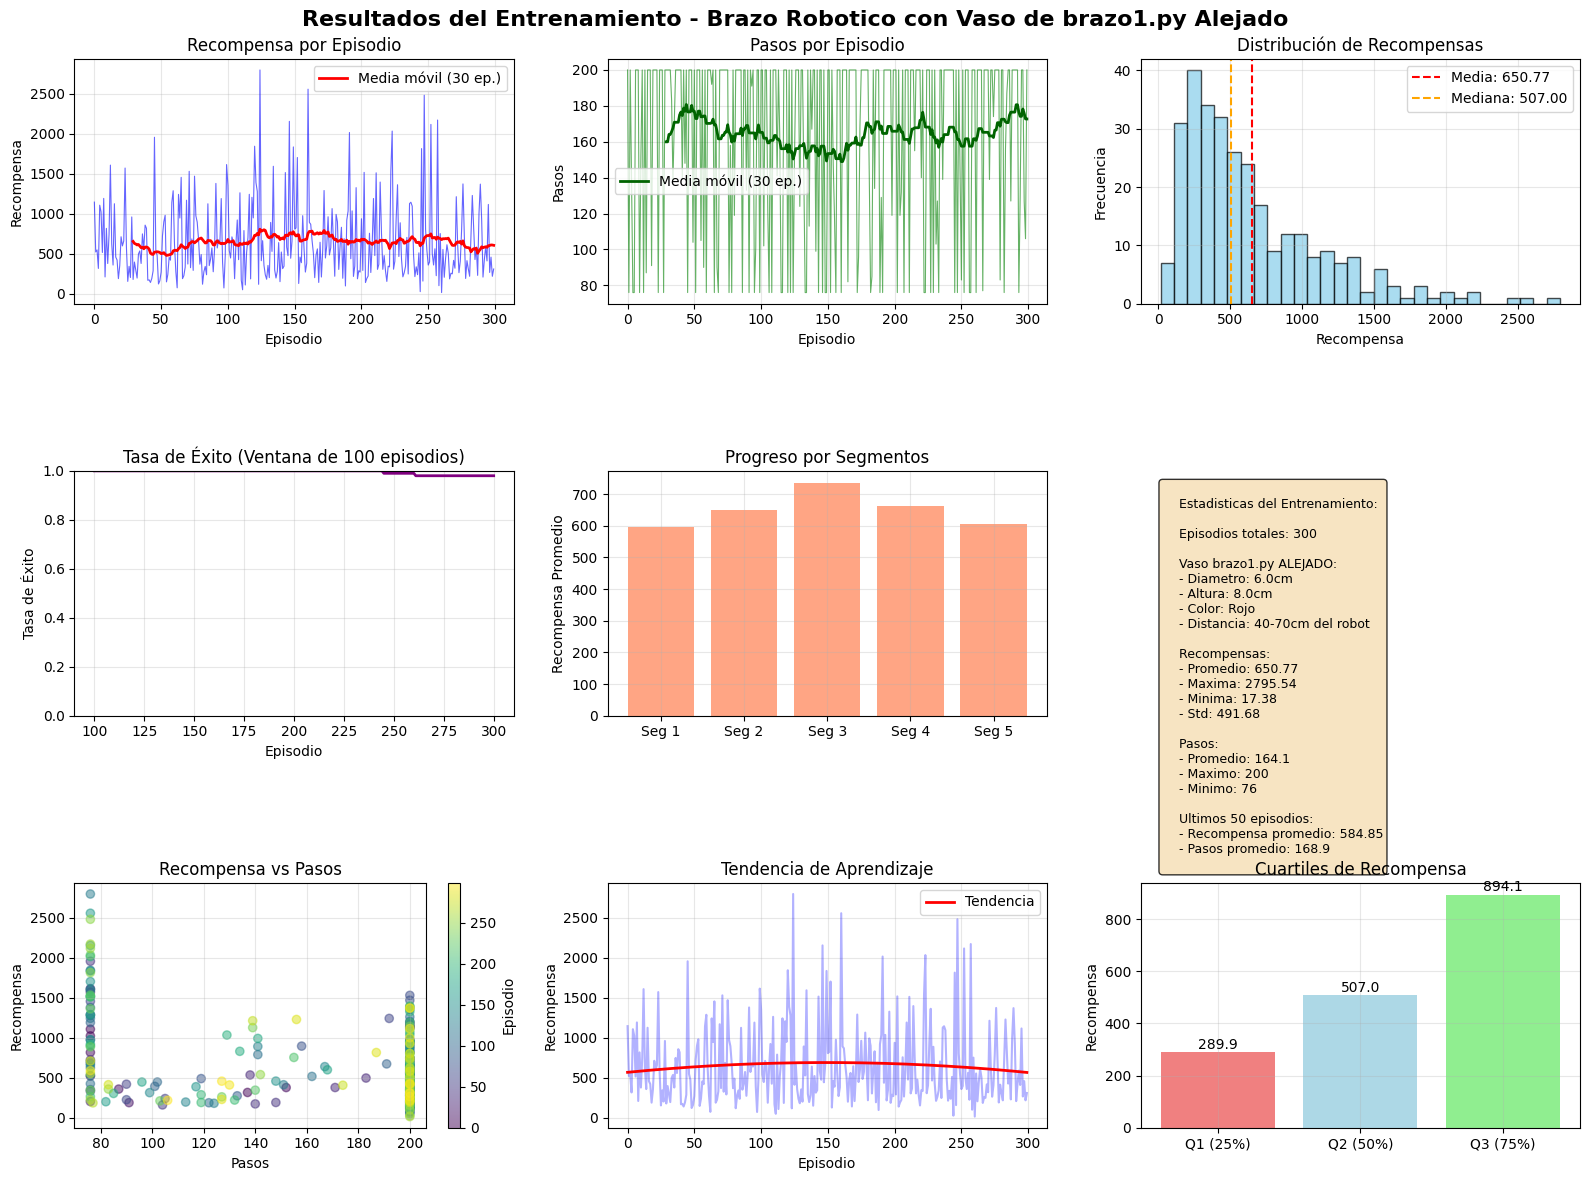

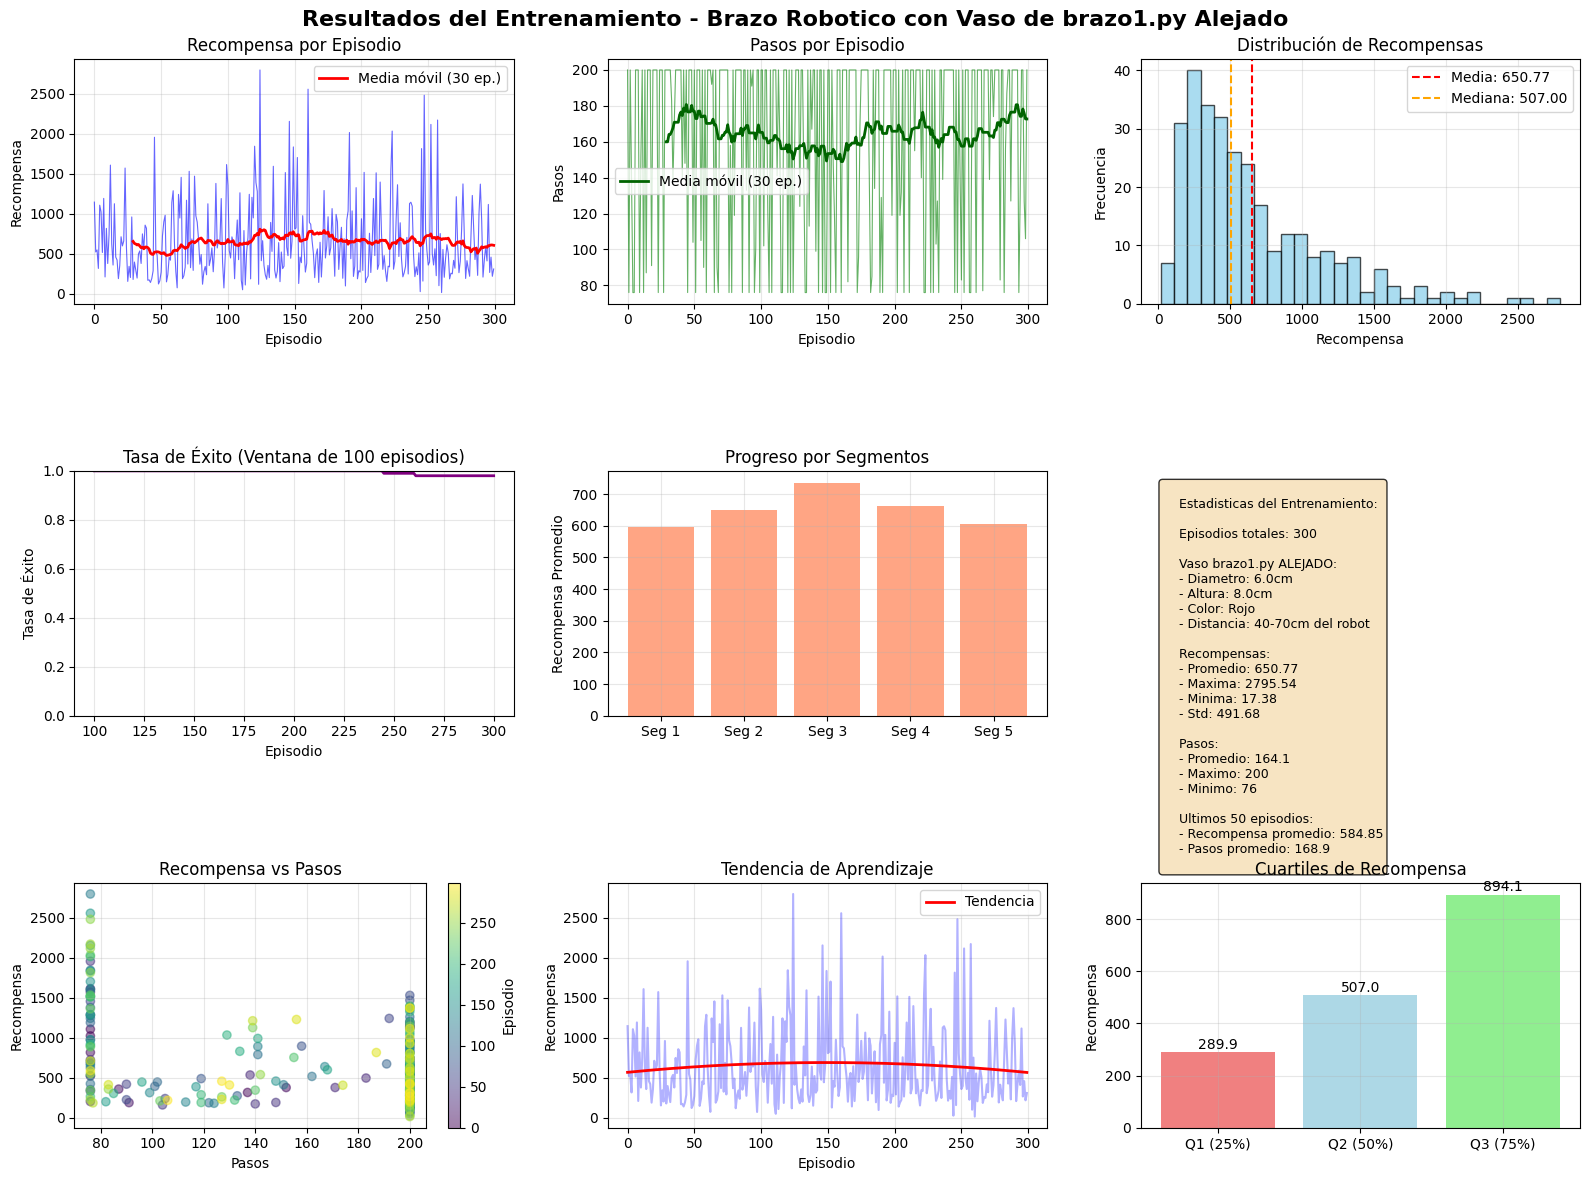

In [11]:
plot_training_results()